In [ ]:
%%capture
!test -d ./TCC-EEG && rm -r TCC-EEG
%cd /content/
!git clone https://github.com/TheoMoutakanni/TCC-EEG.git
%cd /content/TCC-EEG/
!pip install -U https://api.github.com/repos/braindecode/braindecode/zipball/master

In [80]:
%load_ext autoreload 
%autoreload 1
%aimport models, utils
from importlib import reload
reload(models.contrastive)
reload(utils.plot)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils.plot' from '/home/theo/Documents/TCC-EEG/utils/plot.py'>

In [1]:
import mne
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode.datasets.base import BaseConcatDataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skorch.callbacks import EpochScoring, ProgressBar
from skorch.helper import predefined_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import torch

from utils.datasets import get_sleep_physionet, split_dataset, list_of_train_sets, TimeContrastiveDataset
from utils.skorch import EEGTransformer
from utils.linear import plot_knn, compute_dist_to_knn
from utils.plot import (sleep_cmap, rand_cmap, plot_embeddings, get_ages, get_sleep_stages, get_subjects, get_recording, get_sex)
from models.contrastive import ContrastiveModule, EncoderNet, ClassifierNet, train_and_test

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Dataset Creation

In [3]:
%%capture
# full dataset, to get a small one, use: get_sleep_physionet(range(10))
windows_dataset, info = get_sleep_physionet()

In [4]:
self_train_set, self_valid_set, full_train_set, valid_set, test_set, subjects_dic = split_dataset(windows_dataset)
print(len(self_train_set), len(self_valid_set), len(full_train_set), len(valid_set), len(test_set))

115813 17622 133435 16156 18058


In [5]:
splitted = windows_dataset.split('subject')
all_valid_set = TimeContrastiveDataset([splitted[s] for s in subjects_dic['self_valid_subjects'] + subjects_dic['valid_subjects']], delta_index_positive=5, delta_index_negative=20)

In [6]:
mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 4': 3,
    'Sleep stage 3': 3,
    'Sleep stage R': 4
}
reverse_mapping = {v: k[-1] for k,v in mapping.items()}

In [7]:
sleep_stages = get_sleep_stages(all_valid_set)
ages = get_ages(all_valid_set, info)
subjects = get_subjects(all_valid_set)
recording = get_recording(all_valid_set)
sex = get_sex(all_valid_set, info)

# Baseline

## Sleep stages analysis

In [42]:
all_epochs = mne.concatenate_epochs([windows_dataset.datasets[i].windows for i in range(len(windows_dataset.datasets))])

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
167649 matching events found
No baseline correction applied
0 bad epochs dropped


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


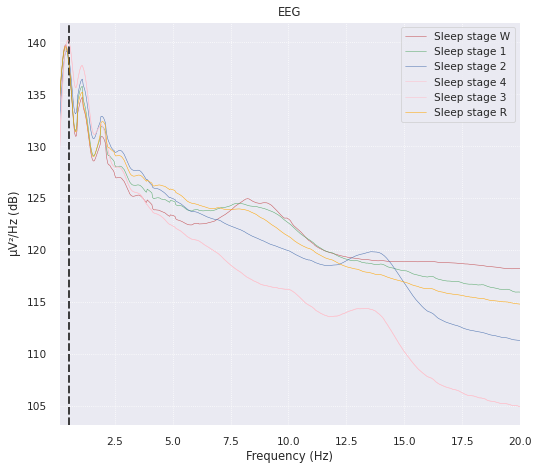

In [43]:
for stage in mapping.keys():
    if stage == 'Sleep stage 4':
        continue
    all_epochs[stage].plot_psd(area_mode=None, color=sleep_cmap(mapping[stage]), ax=plt.gca(),
                           fmin=0.1, fmax=20., show=False, n_jobs=-1,
                           average=True, spatial_colors=False)
plt.legend(plt.gca().lines[2::3], mapping.keys())
plt.savefig('img/freq.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))

## PSD as features

In [47]:
valid_data = np.array([all_valid_set[i][0][0] for i in range(len(all_valid_set))])
fft_data = np.abs(np.fft.fft(valid_data))
fft_data = fft_data.reshape(fft_data.shape[0], -1)

In [48]:
pca_fft = PCA(2)
pca_baseline = pca_fft.fit_transform(fft_data)

tsne_fft = TSNE(2, n_jobs=-1)
tsne_baseline = tsne_fft.fit_transform(fft_data)

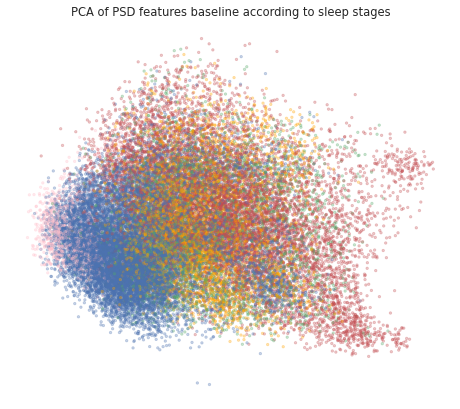

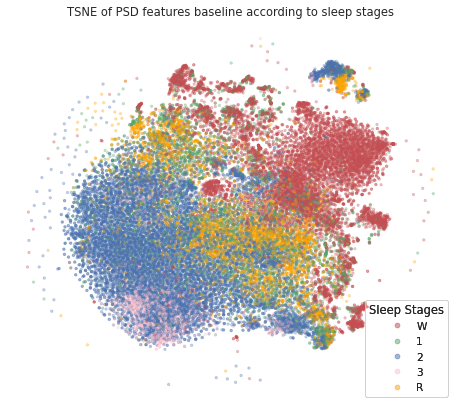

In [49]:
plot_embeddings(pca_baseline, sleep_stages, sleep_cmap, colorbar=False)
plt.savefig('img/PCA_baseline_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("PCA of PSD features baseline according to sleep stages");

plt.figure()
plot_embeddings(tsne_baseline, sleep_stages, sleep_cmap, legend_dict={'title': 'Sleep Stages', 'color_mapping': reverse_mapping}, colorbar=False, legend_loc="lower right")
plt.savefig('img/TSNE_baseline_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("TSNE of PSD features baseline according to sleep stages");

## Using prior knowledge : power band

In [50]:
from scipy import signal

def eeg_power_band(epochs):
    """EEG relative power band feature extraction.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    freqs, psds = signal.welch(epochs, fs=100)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))
    return np.concatenate(X, axis=1)

In [51]:
power_band_data = eeg_power_band(valid_data)

In [52]:
power_band_data.mean(0)

array([0.05233356, 0.04652449, 0.0074046 , 0.01268623, 0.00389594,
       0.00823151, 0.00238645, 0.00309596, 0.0012279 , 0.00165482],
      dtype=float32)

In [53]:
pca_power_band = PCA(2)
pca_baseline_2 = pca_power_band.fit_transform(power_band_data)

tsne_power_band = TSNE(2, n_jobs=-1)
tsne_baseline_2 = tsne_power_band.fit_transform(power_band_data)

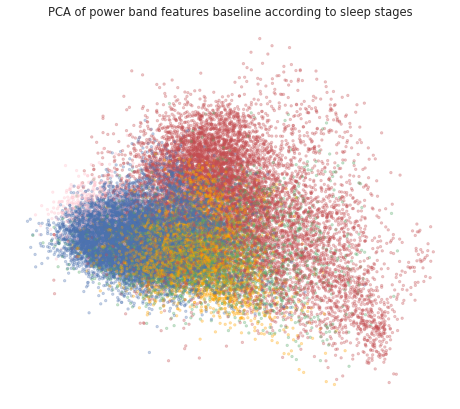

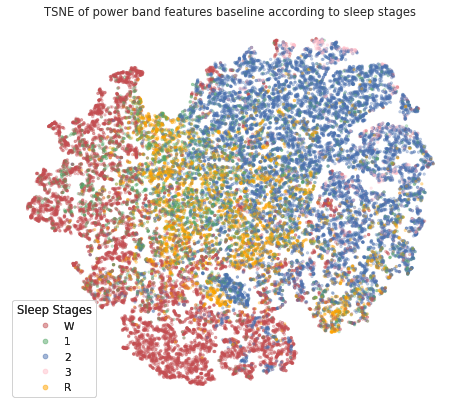

In [54]:
plot_embeddings(pca_baseline_2, sleep_stages, sleep_cmap, colorbar=False)
plt.savefig('img/PCA_baseline_2_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("PCA of power band features baseline according to sleep stages");

plt.figure()
plot_embeddings(tsne_baseline_2, sleep_stages, sleep_cmap, legend_dict={'title': 'Sleep Stages', 'color_mapping': reverse_mapping}, colorbar=False, legend_loc="lower left")
plt.savefig('img/TSNE_baseline_2_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("TSNE of power band features baseline according to sleep stages");

# Contrastive Task Training

## Encoder Training

In [8]:
# Encoder
n_channels = 2
p_dropout = 0.2
window_size = 30
sfreq = 100

encoder = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_classes=128,
    n_conv_chs=16,
    input_size_s=window_size,
    dropout=p_dropout,
)
encoder.num_features = 128
#encoder = EncoderNet(feat_per_layer=[32, 64, 128], n_channels=n_channels, p_dropout=p_dropout, apply_batch_norm=False)
network = ContrastiveModule(encoder)

In [9]:
network = torch.load('contrastive_network.pt')
encoder = network.encoder
with open('contrastive_network.pkl', 'rb') as f:
    skorch_net = pickle.load(f)

In [8]:
#Training
lr = 5e-4
batch_size = 100
max_nb_epochs = 40
early_stopping_patience = 5

skorch_net = network.train_(
    self_train_set, self_valid_set, lr=lr, batch_size=batch_size,
    max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience)

  epoch    train_bal_acc    train_loss    valid_bal_acc    valid_loss       dur
-------  ---------------  ------------  ---------------  ------------  --------
      1           0.7596        0.5008           0.7492        0.5139  129.8360


      2           0.7834        0.4679           0.7803        0.4743  111.6950


      3           0.7896        0.4557           0.7832        0.4631  110.3143


      4           0.7965        0.4453           0.7951        0.4565  111.2216


      5           0.8007        0.4389           0.7905        0.4524  113.2863


      6           0.8027        0.4355           0.7941        0.4483  112.1067


      7           0.8059        0.4297           0.7885        0.4567  111.9489


      8           0.8090        0.4229           0.7953        0.4429  112.4184


      9           0.8093        0.4247           0.7961        0.4449  112.2168


     10           0.8114        0.4221           0.7913        0.4448  111.6838


     11           0.8123        0.4195           0.8043        0.4280  112.4567


     12           0.8126        0.4167           0.8074        0.4312  110.6876


     13           0.8147        0.4168           0.8042        0.4303  106.5199


     14           0.8141        0.4152           0.8027        0.4305  105.8817


     15           0.8163        0.4135           0.8090        0.4275  106.6360


     16           0.8140        0.4151           0.8019        0.4303  106.2389


     17           0.8166        0.4129           0.8143        0.4180  105.8428


     18           0.8179        0.4090           0.8025        0.4343  106.0489


     19           0.8186        0.4094           0.8162        0.4161  106.1804


     20           0.8192        0.4063           0.8024        0.4313  106.0616


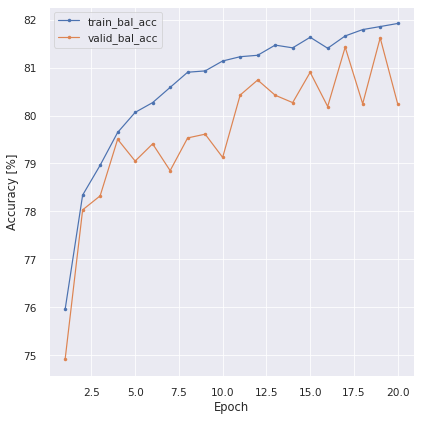

In [74]:
# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(skorch_net.history.to_list())

fig = plt.figure(figsize=(6, 6))
plt.plot(df['epoch'], df['train_bal_acc'] * 100, ls='-', marker='.', ms=7, label='train_bal_acc')
plt.plot(df['epoch'], df['valid_bal_acc'] * 100, ls='-', marker='.', ms=7, label='valid_bal_acc')

plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')

plt.legend()
plt.tight_layout()
plt.savefig('img/training.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))

In [9]:
torch.save(network, 'contrastive_network.pt')
with open('contrastive_network.pkl', 'wb') as f:
    pickle.dump(skorch_net, f)

## Predictions

In [26]:
# Embeddings
embds = skorch_net.transform(all_valid_set)[::2]

In [ ]:
# PCA
pca = PCA(2)
pca_embds = pca.fit_transform(embds)
# TSNE
tsne = TSNE(2, n_jobs=-1)
tsne_embds = tsne.fit_transform(embds)

In [18]:
print('Explained variance (%) for PCA with 2 components: ', pca.explained_variance_ratio_.sum())

Explained variance (%) for PCA with 2 components:  0.67235637


In [69]:
train_embds = skorch_net.transform(self_train_set)[::2]
train_subjects = get_subjects(self_train_set)
train_recording = get_recording(self_train_set)
train_sleep_stages = get_sleep_stages(self_train_set)
train_ages_per_subject = [info[info['subject'] == subject_id]['age'].iloc[0] for subject_id in np.unique(train_subjects)]

NameError: name 'train_subjectsi' is not defined

In [305]:
dist_list_1 = []
dist_list_2 = []
dist_list_all = []
for subject_id in tqdm(np.unique(train_subjects)):
    distances_1 = compute_dist_to_knn(train_embds[(train_subjects==subject_id) & (train_recording == 1)], k='auto')
    dist_list_1.append(np.mean(distances_1))

    distances_2 = compute_dist_to_knn(train_embds[(train_subjects==subject_id) & (train_recording == 2)], k='auto')
    dist_list_2.append(np.mean(distances_2))
    dist_list_all.append(np.concatenate([distances_1, distances_2]))
dist_list_1 = np.array(dist_list_1)
dist_list_2 = np.array(dist_list_2)
dist_list_all = np.array([np.mean(x) for x in dist_list_all])

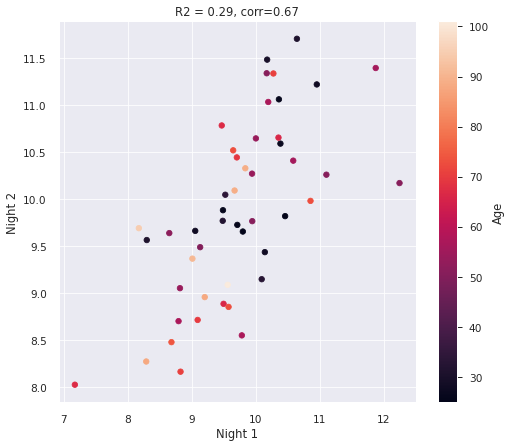

In [306]:
plt.scatter(dist_list_1, dist_list_2, c=train_ages_per_subject, s=30)
plt.xlabel('Night 1')
plt.ylabel('Night 2')
plt.title('R2 = {:0.2f}, corr={:0.2f}'.format(r2_score(dist_list_1, dist_list_2),
                                              np.corrcoef(dist_list_1, dist_list_2)[0,1]))
cbar = plt.colorbar()
cbar.set_label('Age')
plt.savefig('img/mean_dist.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))

In [308]:
sleep_stages_dist = {}
for sleep_st in [0,1,2,3,4]:
    dist_list_1 = []
    dist_list_2 = []
    dist_list_all = []
    for subject_id in tqdm(np.unique(train_subjects)):
        distances_1 = compute_dist_to_knn(train_embds[(train_subjects==subject_id) & (train_recording == 1) & (train_sleep_stages == sleep_st)], k='auto')
        dist_list_1.append(np.mean(distances_1))
        
        distances_2 = calc_dist(train_embds[(train_subjects==subject_id) & (train_recording == 2) & (train_sleep_stages == sleep_st)], k='auto')
        dist_list_2.append(np.mean(distances_2))
        dist_list_all.append(np.concatenate([distances_1, distances_2]))
    dist_list_1 = np.array(dist_list_1)
    dist_list_2 = np.array(dist_list_2)
    dist_list_all = np.array([np.mean(x[x != 0]) for x in dist_list_all])
    sleep_stages_dist[sleep_st] = [dist_list_1, dist_list_2, dist_list_all]

Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0
Warning, k==0



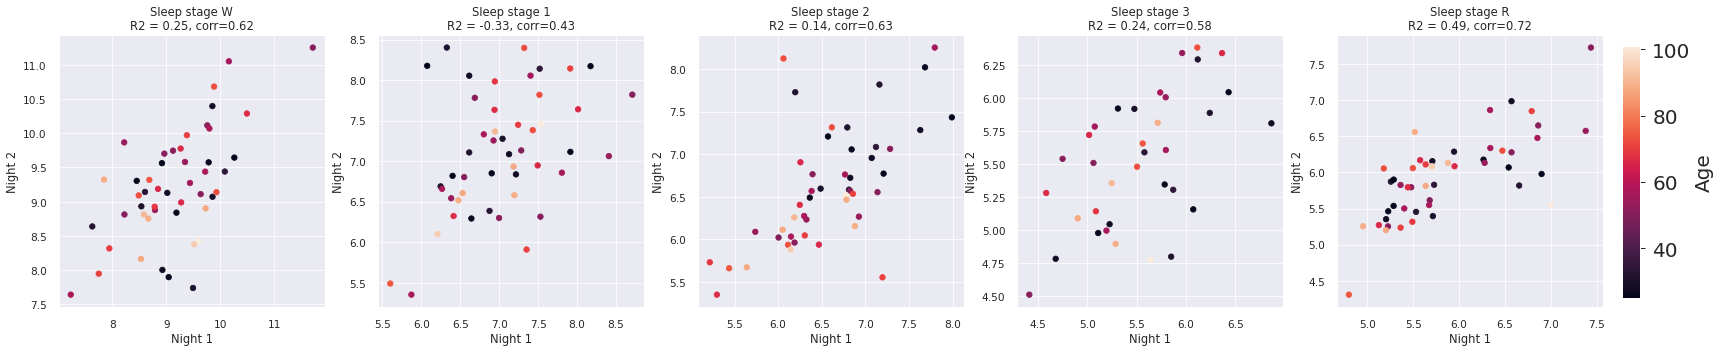

In [350]:
fig = plt.figure(figsize=(26,5))
for sleep_st in [0,1,2,3,4]:
    plt.subplot(1,5,sleep_st+1)
    keep = (sleep_stages_dist[sleep_st][0] != 0) & (sleep_stages_dist[sleep_st][1] != 0) & ~np.isnan(sleep_stages_dist[sleep_st][0]) & ~np.isnan(sleep_stages_dist[sleep_st][1])
    im = plt.scatter(sleep_stages_dist[sleep_st][0][keep], sleep_stages_dist[sleep_st][1][keep], c=np.array(train_ages_per_subject)[keep], s=30)
    plt.xlabel('Night 1')
    plt.ylabel('Night 2')
    plt.title('Sleep stage {}\nR2 = {:0.2f}, corr={:0.2f}'.format(reverse_mapping[sleep_st],
                                                      r2_score(sleep_stages_dist[sleep_st][0][keep], sleep_stages_dist[sleep_st][1][keep]),
                                                      np.corrcoef(sleep_stages_dist[sleep_st][0][keep], sleep_stages_dist[sleep_st][1][keep])[0,1]))
# Put colorbar to the right
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, drawedges=False)
cb.ax.tick_params(labelsize=20)
cb.set_label('Age', fontsize=20)

plt.savefig('img/mean_dist_splitted.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))


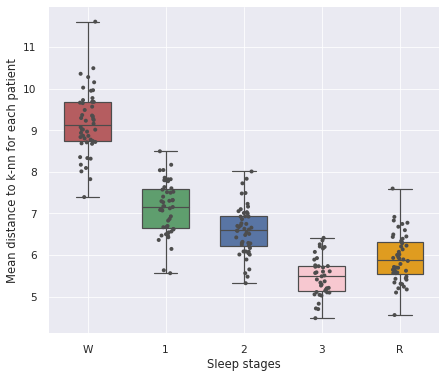

In [341]:
f, ax = plt.subplots(figsize=(7, 6))

mpl.cm.register_cmap("sleep_cmap", sleep_cmap)

sns.boxplot(x=np.repeat([reverse_mapping[i] for i in range(5)], len(sleep_stages_dist[sleep_st][2])), y=np.array([sleep_stages_dist[sleep_st][2] for sleep_st in range(5)]).flatten(),
            whis=[0, 100], width=.6, palette="sleep_cmap")
sns.stripplot(x=np.repeat([reverse_mapping[i] for i in range(5)], len(sleep_stages_dist[sleep_st][2])), y=np.array([sleep_stages_dist[sleep_st][2] for sleep_st in range(5)]).flatten(),
              size=4, color=".3", linewidth=0)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt.xlabel("Sleep stages")
plt.ylabel("Mean distance to k-nn for each patient")
plt.savefig('img/mean_dist_per_sleep.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))

# Plots

In [19]:
new_cmap = rand_cmap(max(subjects)+1, type='bright', first_color_black=True,
                     last_color_black=False, verbose=False)

In [20]:
with open('cmap.pkl', 'rb') as f:
    new_cmap = pickle.load(f)

## Sleep Stages

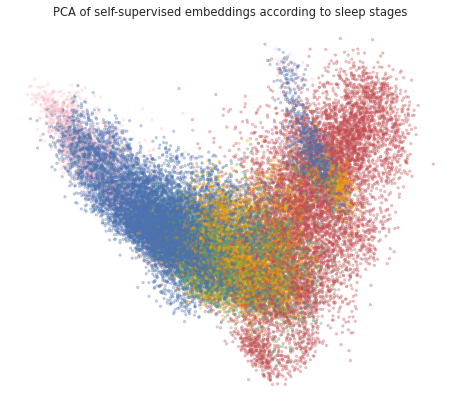

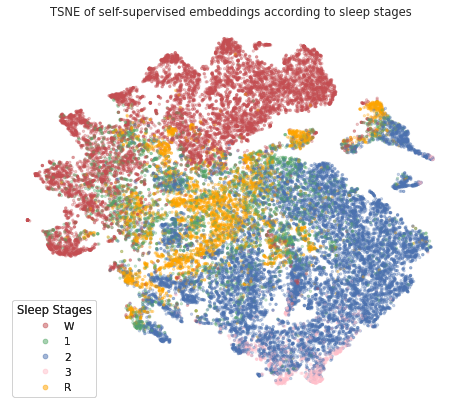

In [41]:
plot_embeddings(pca_embds, sleep_stages, sleep_cmap, colorbar=False)
plt.savefig('img/PCA_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("PCA of self-supervised embeddings according to sleep stages");

plt.figure()
plot_embeddings(tsne_embds, sleep_stages, sleep_cmap, legend_dict={'title': 'Sleep Stages', 'color_mapping': reverse_mapping}, colorbar=False, legend_loc="lower left")
plt.savefig('img/TSNE_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("TSNE of self-supervised embeddings according to sleep stages");

## Age

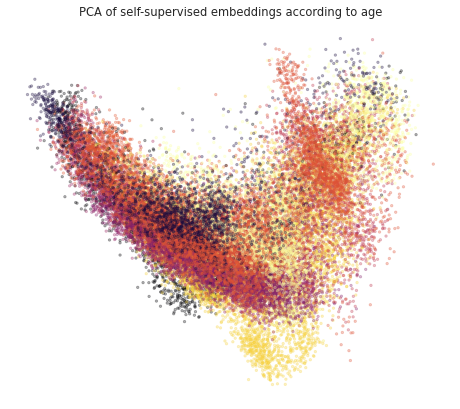

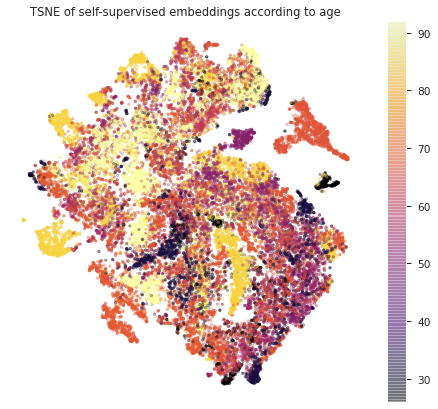

In [22]:
plot_embeddings(pca_embds, ages, plt.get_cmap('inferno'), colorbar=False)
plt.savefig('img/PCA_age.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('PCA of self-supervised embeddings according to age')

plt.figure()
plot_embeddings(tsne_embds, ages, plt.get_cmap('inferno'))
plt.savefig('img/TSNE_age.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('TSNE of self-supervised embeddings according to age');

## Patient ID

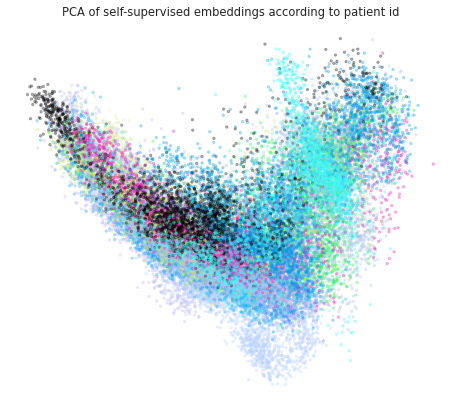

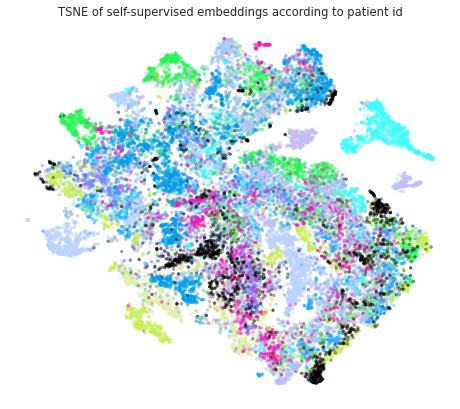

In [56]:
plot_embeddings(pca_embds, subjects, new_cmap, colorbar=False)
plt.savefig('img/PCA_patient.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('PCA of self-supervised embeddings according to patient id')

plt.figure()
plot_embeddings(tsne_embds, subjects, new_cmap, colorbar=False)
plt.savefig('img/TSNE_patient.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('TSNE of self-supervised embeddings according to patient id');

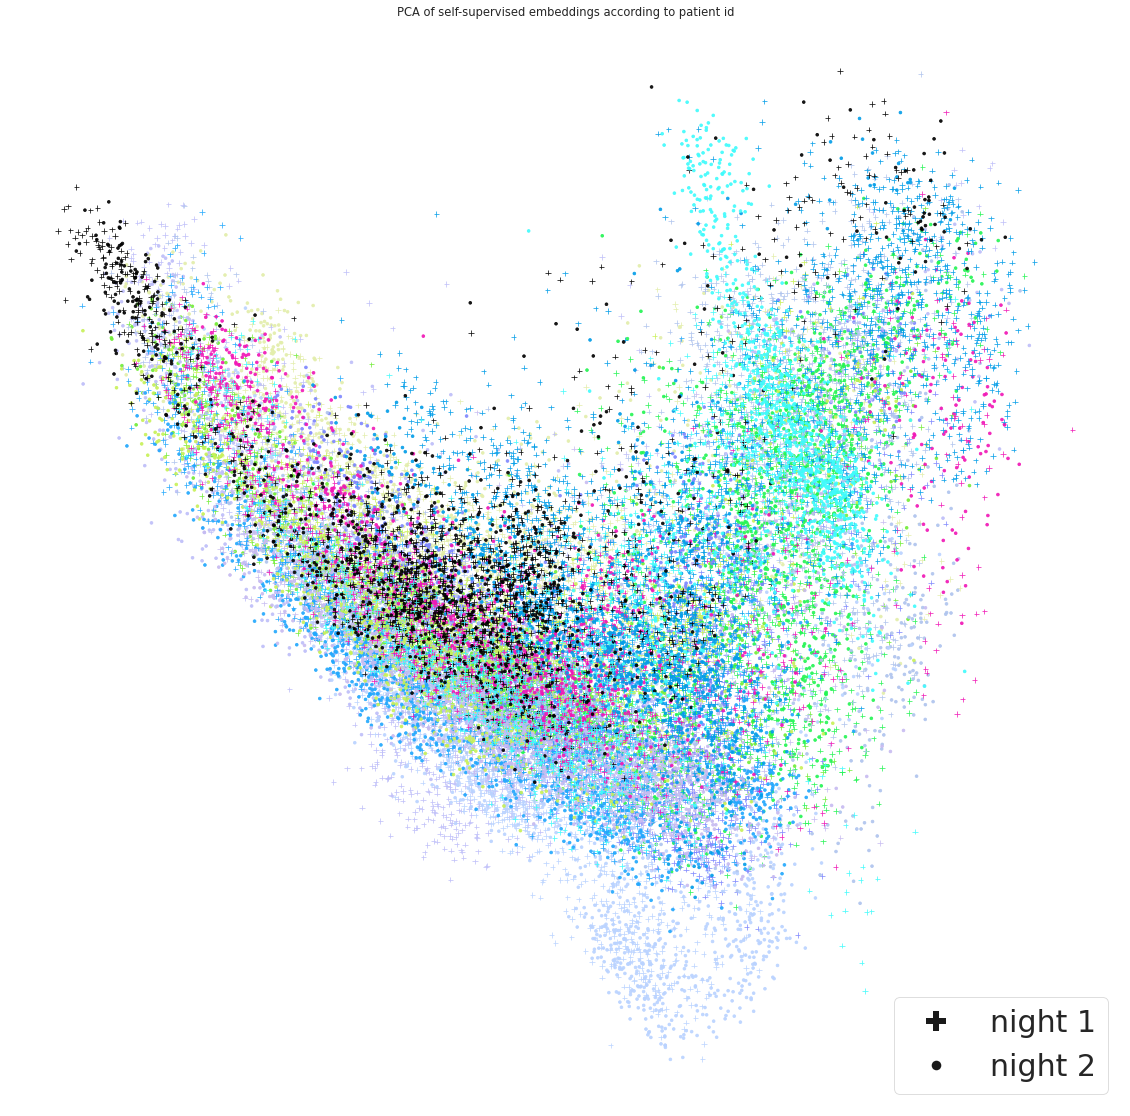

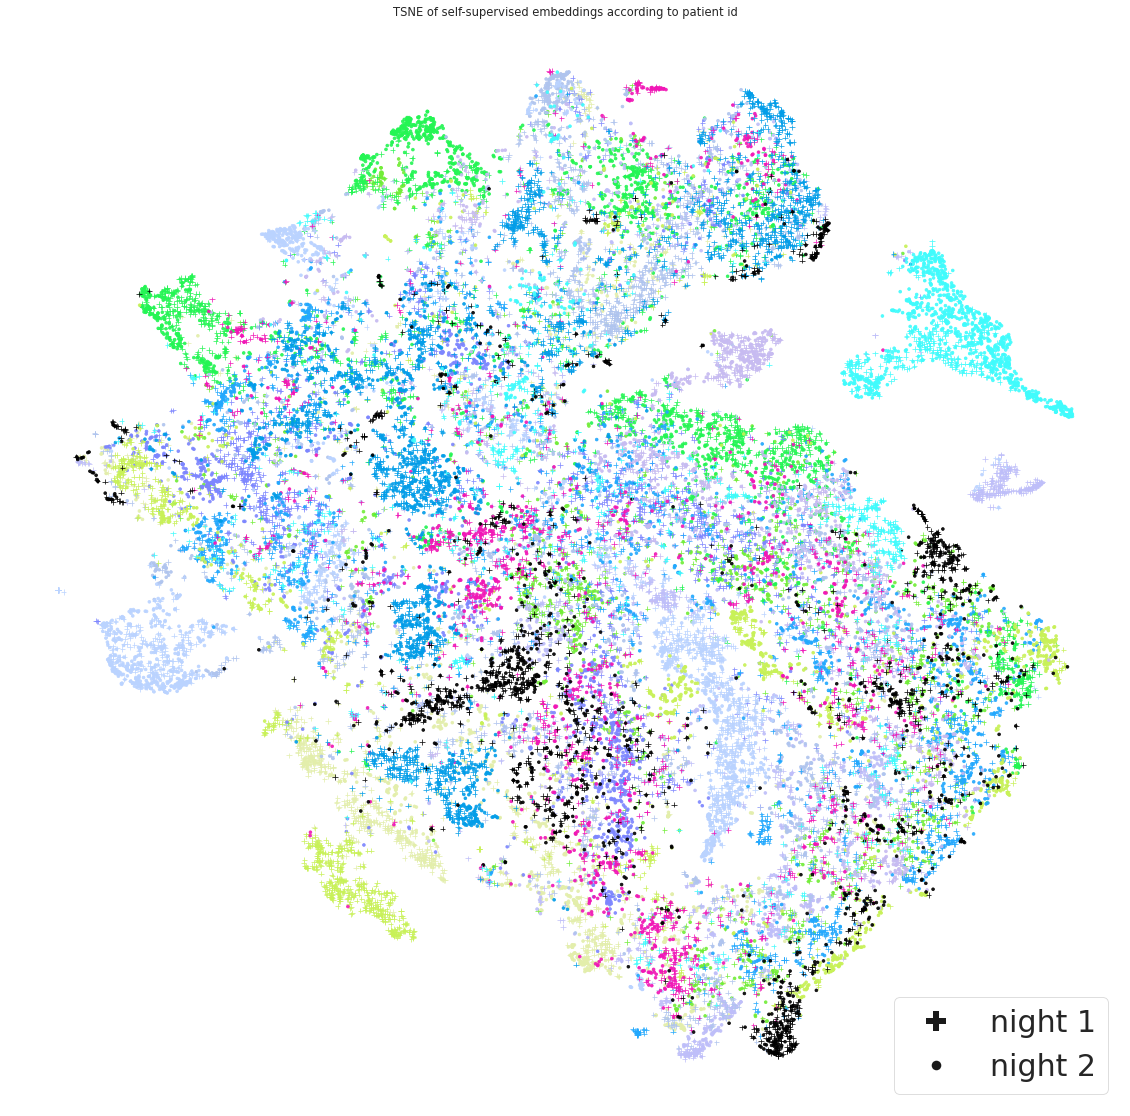

In [57]:
plt.figure(figsize=(20,20))
plot_embeddings(pca_embds, subjects, new_cmap, markers=[{1:'+', 2:'.'}[i] for i in recording], s=30, alpha=0.9, colorbar=False)
f = lambda m: plt.plot([],[],marker=m, color="k", ls="none")[0]
plt.legend([f("P"), f('.')], ["night 1", "night 2"], loc='lower right', markerscale=4., fontsize=30, title_fontsize=30, facecolor='None')
plt.savefig('img/PCA_patient_night.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('PCA of self-supervised embeddings according to patient id')


plt.figure(figsize=(20,20))
plot_embeddings(tsne_embds, subjects, new_cmap, markers=[{1:'+', 2:'.'}[i] for i in recording], s=30, alpha=0.9, colorbar=False)
plt.legend([f("P"), f('.')], ["night 1", "night 2"], loc='lower right', markerscale=4., fontsize=30, title_fontsize=30, facecolor='None')
plt.savefig('img/TSNE_patient_night.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title('TSNE of self-supervised embeddings according to patient id');

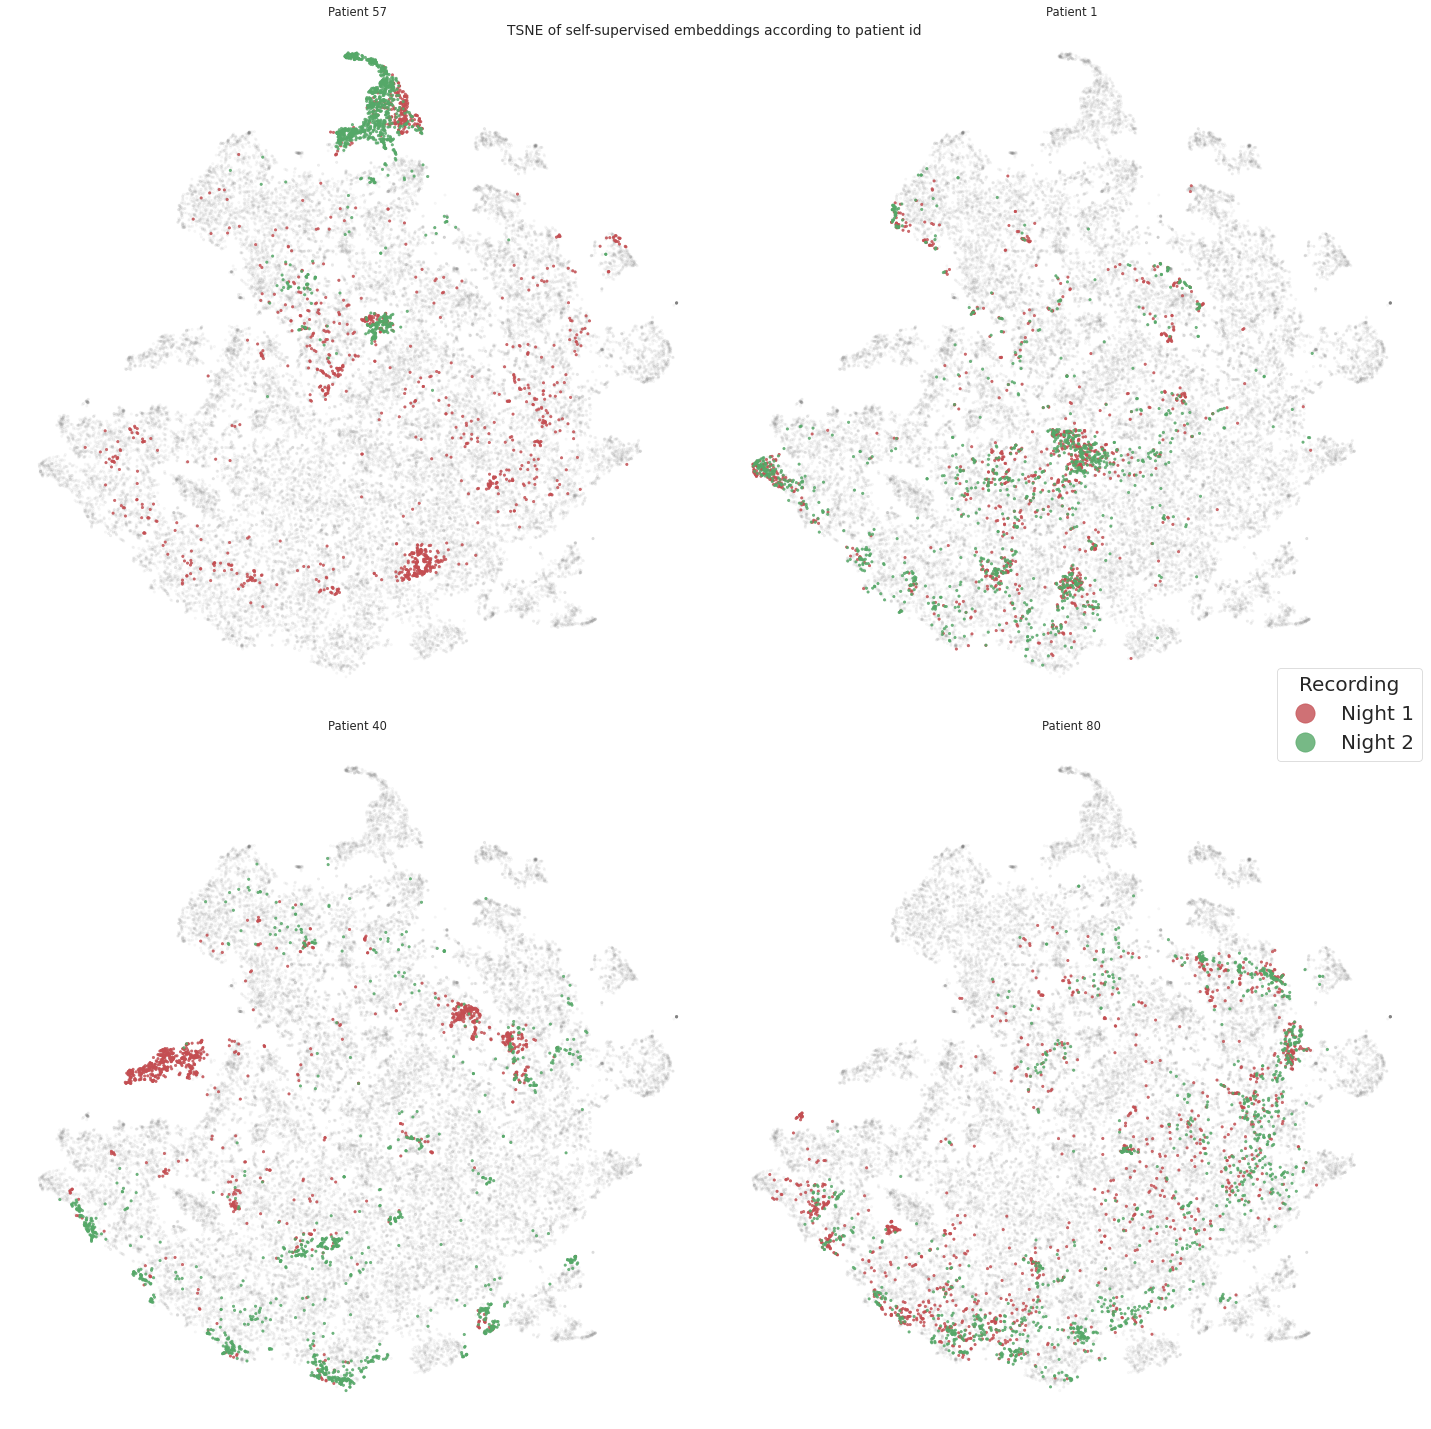

In [13]:
fig = plt.figure(figsize=(20,20))
paired_colors = plt.get_cmap('tab20')
selected_subjects = [57,1,40,80]
for i, subject_id in enumerate(selected_subjects):
    plt.subplot(2,2,i+1)
    plot_embeddings(tsne_embds, subjects, ['grey'], s=5, alpha=0.05, colorbar=False)
    colors = [sleep_cmap(0), sleep_cmap(1)] #[paired_colors(2*(i+1)), paired_colors(2*(i+1)+1)]
    im = plot_embeddings(tsne_embds[subjects==subject_id], recording[subjects==subject_id], colors, s=5, alpha=0.8, colorbar=False)
    plt.title('Patient {}'.format(subject_id))
    
# Add legend to the right
legend = fig.legend(*im.legend_elements(prop="colors"),
                    loc="right", title='Recording', markerscale=4., fontsize=20, title_fontsize=20, facecolor='None')
legend.get_texts()[0].set_text('Night 1')
legend.get_texts()[1].set_text('Night 2')
    
plt.tight_layout()
#plt.savefig('img/TSNE_patient_night_cherrypick.png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=True)
plt.suptitle('TSNE of self-supervised embeddings according to patient id');

In [31]:
np.unique(subjects)

array([ 1, 11, 25, 30, 33, 40, 46, 53, 57, 64, 71, 74, 77, 80])

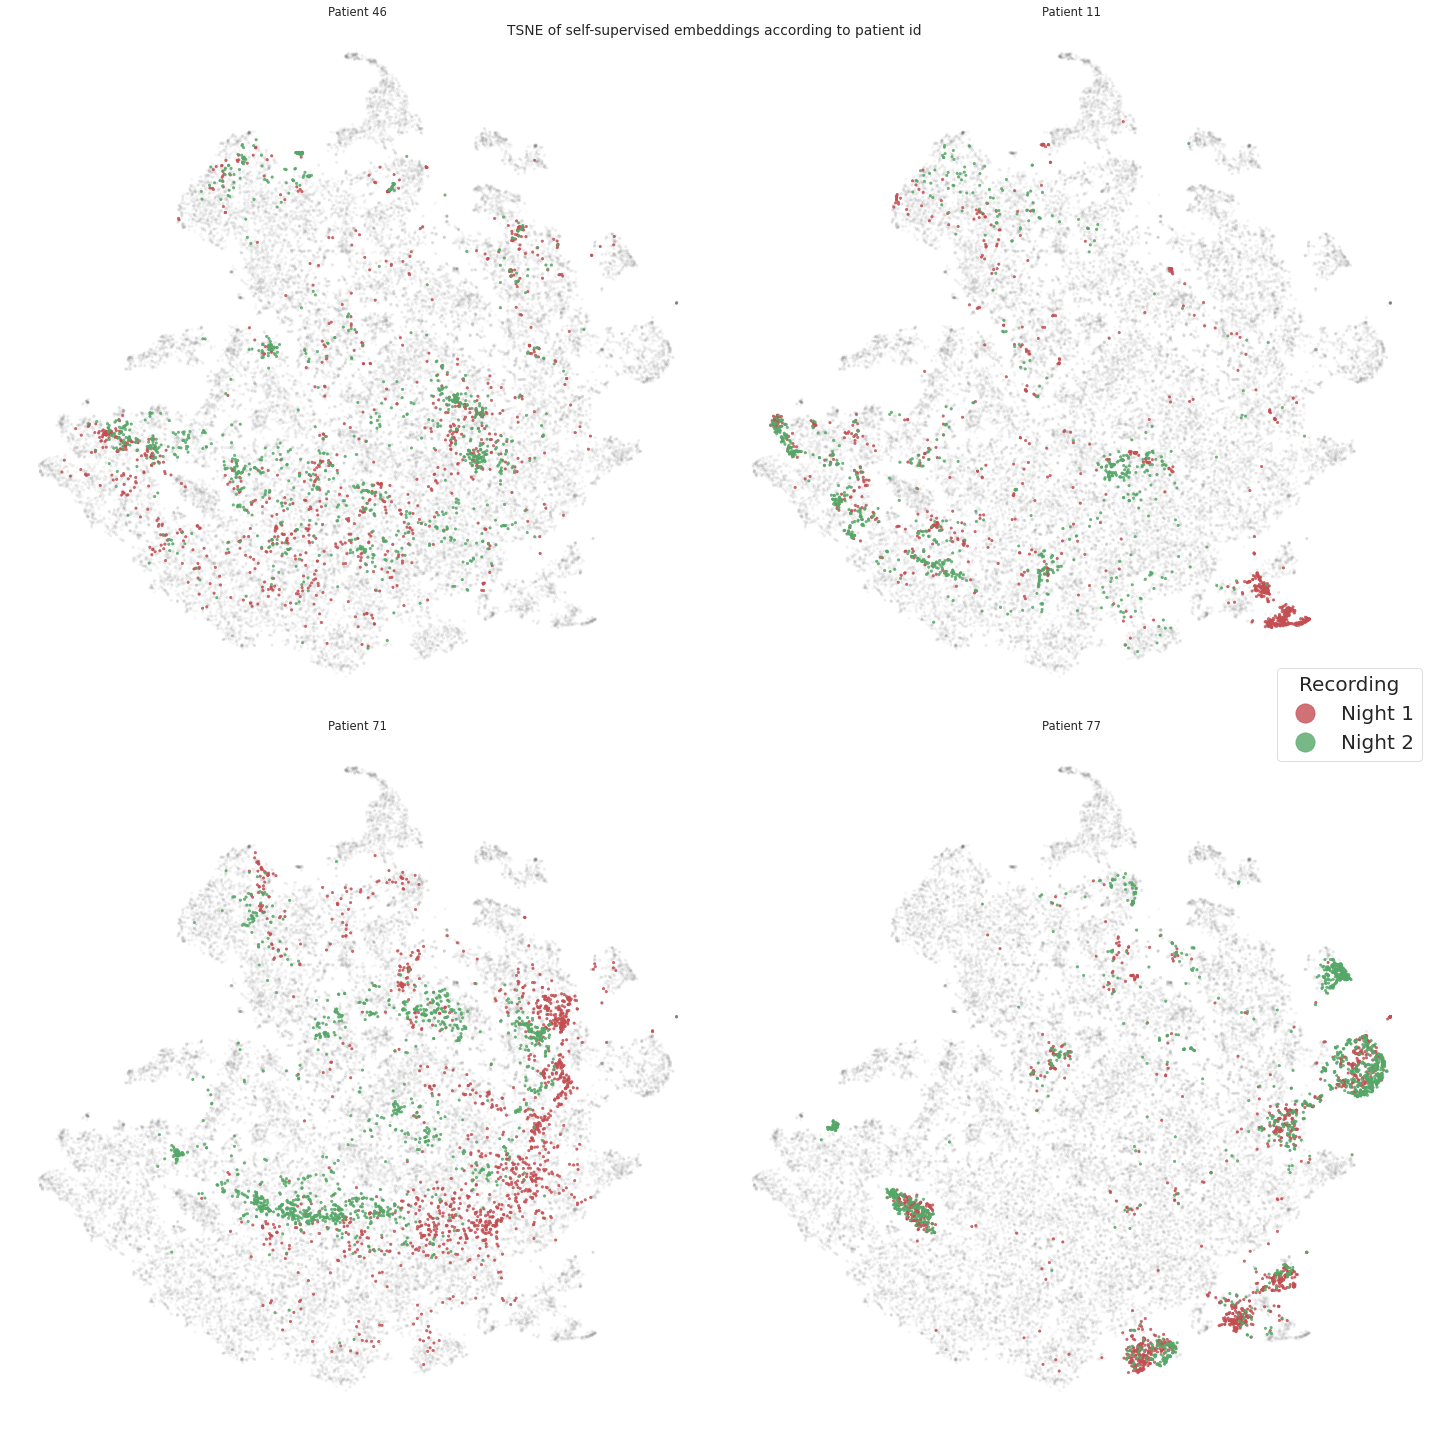

In [14]:
fig = plt.figure(figsize=(20,20))
paired_colors = plt.get_cmap('tab20')
selected_subjects = [46,11,71,77]
for i, subject_id in enumerate(selected_subjects):
    plt.subplot(2,2,i+1)
    plot_embeddings(tsne_embds, subjects, ['grey'], s=5, alpha=0.05, colorbar=False)
    colors = [sleep_cmap(0), sleep_cmap(1)] #[paired_colors(2*(i+1)), paired_colors(2*(i+1)+1)]
    im = plot_embeddings(tsne_embds[subjects==subject_id], recording[subjects==subject_id], colors, s=5, alpha=0.8, colorbar=False)
    plt.title('Patient {}'.format(subject_id))
    
# Add legend to the right
legend = fig.legend(*im.legend_elements(prop="colors"),
                    loc="right", title='Recording', markerscale=4., fontsize=20, title_fontsize=20, facecolor='None')
legend.get_texts()[0].set_text('Night 1')
legend.get_texts()[1].set_text('Night 2')
    
plt.tight_layout()
#plt.savefig('img/TSNE_patient_night_cherrypick_2.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.suptitle('TSNE of self-supervised embeddings according to patient id');

## Sex

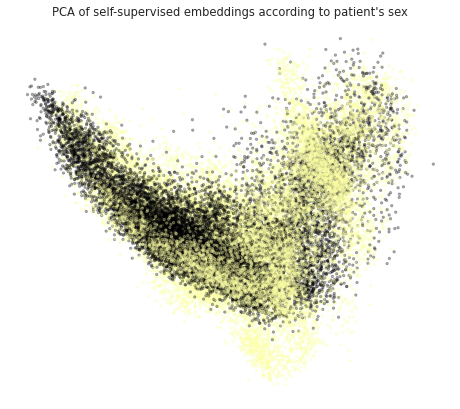

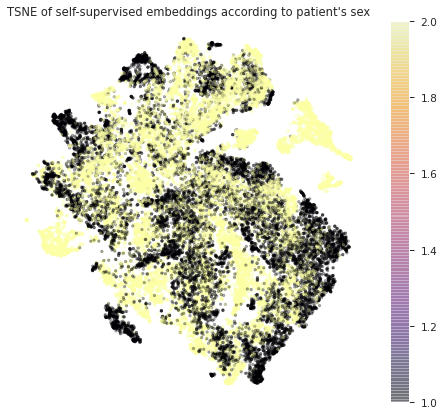

In [25]:
plot_embeddings(pca_embds, sex, plt.get_cmap('inferno'), colorbar=False)
f = lambda m: plt.plot([],[],marker=m, color="k", ls="none")[0]
plt.savefig('img/PCA_sex.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("PCA of self-supervised embeddings according to patient's sex")

plt.figure()
plot_embeddings(tsne_embds, sex, plt.get_cmap('inferno'))
plt.savefig('img/TSNE_sex.png', dpi=200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.title("TSNE of self-supervised embeddings according to patient's sex");

# Comparison against baseline

100%|██████████| 3/3 [04:38<00:00, 92.85s/it]


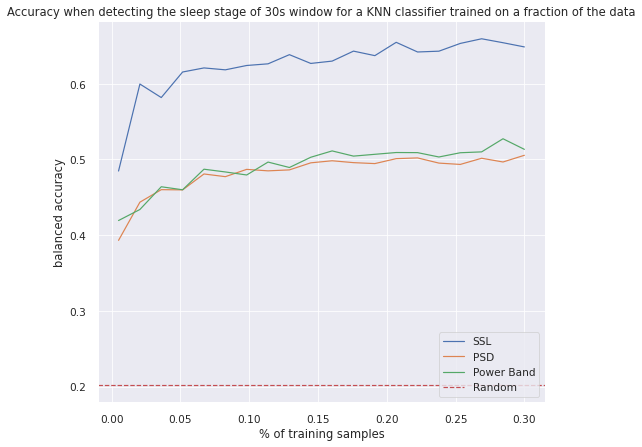

In [64]:
plot_knn([embds, fft_data, power_band_data], sleep_stages, colorbar=False, verbose=1)
plt.legend(['SSL', 'PSD', 'Power Band', 'Random'], loc='lower right')
plt.savefig('img/knn_benchmark_sleep_stages.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title('Accuracy when detecting the sleep stage of 30s window for a KNN classifier trained on a fraction of the data');

100%|██████████| 3/3 [04:33<00:00, 91.25s/it]


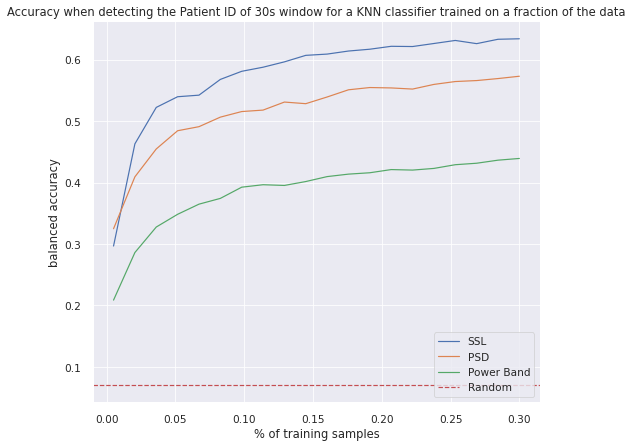

In [65]:
plot_knn([embds, fft_data, power_band_data], subjects, colorbar=False, verbose=1)
plt.legend(['SSL', 'PSD', 'Power Band', 'Random'], loc='lower right')
plt.savefig('img/knn_benchmark_patient.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title('Accuracy when detecting the Patient ID of 30s window for a KNN classifier trained on a fraction of the data');

# Downstream task

In [26]:
train_sets = list_of_train_sets(subjects_dic["full_train_subjects"], windows_dataset)

In [34]:
lr = 5e-4
batch_size = 64
max_nb_epochs = 40
early_stopping_patience = 5

acc_list = []
for train_set in train_sets[::5]:
    classifier_net = ClassifierNet(encoder, p_dropout=0.2)
    _, acc = train_and_test(classifier_net, train_set, valid_set, test_set=test_set, lr=lr, batch_size=batch_size,
                            max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience, train_what="last")
    acc_list.append(acc)
    print("acc:", acc)

  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.3730        1.3428       0.5795           0.3490        1.3454  1.4358


      2           0.4412        1.2244       0.5916           0.4013        1.3311  1.3832


      3           0.5516        1.1786       0.5685           0.4053        1.3346  1.4513


      4           0.5710        1.1516       0.5794           0.4118        1.3208  1.4372


      5           0.5821        1.1405       0.5633           0.4113        1.3379  1.4425


      6           0.5943        1.1293       0.5568           0.4131        1.3504  1.4226


      7           0.5918        1.1276       0.5615           0.4190        1.3431  1.3432


      8           0.5993        1.1226       0.5763           0.4223        1.3223  1.3156


      9           0.5993        1.1189       0.5653           0.4128        1.3334  1.3554


     10           0.5973        1.1151       0.5644           0.4151        1.3337  1.3893


     11           0.6072        1.1108       0.5701           0.4157        1.3260  1.4770


     12           0.6049        1.1127       0.5697           0.4179        1.3280  1.5012


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.6672942740059807


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4570        1.2761       0.6614           0.4470        1.2412  2.4496


      2           0.5145        1.2124       0.6577           0.4586        1.2429  2.5062


      3           0.5240        1.2045       0.6545           0.4543        1.2430  2.5841


      4           0.5322        1.1985       0.6565           0.4523        1.2420  2.6579


      5           0.5387        1.1948       0.6643           0.4619        1.2320  2.5693


      6           0.5410        1.1906       0.6606           0.4598        1.2355  2.5121


      7           0.5449        1.1872       0.6684           0.4709        1.2300  2.5894


      8           0.5476        1.1848       0.6602           0.4577        1.2348  2.5958


      9           0.5527        1.1834       0.6567           0.4631        1.2386  2.6601


     10           0.5524        1.1820       0.6584           0.4640        1.2369  2.5175


     11           0.5562        1.1783       0.6624           0.4707        1.2353  2.6292


     12           0.5561        1.1784       0.6605           0.4711        1.2361  2.3862


     13           0.5629        1.1746       0.6683           0.4689        1.2294  2.3454


     14           0.5599        1.1765       0.6751           0.4795        1.2219  2.4876


     15           0.5599        1.1759       0.6718           0.4712        1.2240  2.5159


     16           0.5618        1.1734       0.6744           0.4689        1.2230  2.3728


     17           0.5622        1.1731       0.6761           0.4761        1.2208  2.2901


     18           0.5621        1.1728       0.6768           0.4732        1.2205  2.3775


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7452098792778824


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4843        1.2187       0.6605           0.4485        1.2415  3.4495


      2           0.5099        1.1806       0.6579           0.4447        1.2411  3.7521


      3           0.5229        1.1721       0.6637           0.4642        1.2363  3.6772


      4           0.5306        1.1687       0.6651           0.4681        1.2338  3.5800


      5           0.5329        1.1659       0.6650           0.4647        1.2325  3.7467


      6           0.5394        1.1630       0.6679           0.4601        1.2318  3.7018


      7           0.5383        1.1620       0.6725           0.4670        1.2256  3.9231


      8           0.5420        1.1608       0.6523           0.4617        1.2447  3.5268


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7508029682135342


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4867        1.2056       0.6597           0.4490        1.2415  4.8555


      2           0.5129        1.1797       0.6625           0.4521        1.2369  5.2417


      3           0.5229        1.1728       0.6669           0.4636        1.2314  5.2381


      4           0.5312        1.1691       0.6702           0.4648        1.2286  5.2774


      5           0.5354        1.1657       0.6696           0.4668        1.2304  5.3205


      6           0.5385        1.1635       0.6702           0.4688        1.2274  5.0350


      7           0.5415        1.1629       0.6715           0.4723        1.2274  5.1638


      8           0.5422        1.1612       0.6719           0.4689        1.2271  5.0845


      9           0.5445        1.1597       0.6750           0.4731        1.2250  4.9079


     10           0.5479        1.1590       0.6731           0.4747        1.2255  5.0817


     11           0.5493        1.1573       0.6703           0.4683        1.2292  5.1247


     12           0.5502        1.1569       0.6752           0.4767        1.2231  5.0833


     13           0.5514        1.1568       0.6729           0.4683        1.2260  5.2020


     14           0.5538        1.1550       0.6739           0.4870        1.2250  5.1680


     15           0.5544        1.1541       0.6733           0.4798        1.2260  5.0245


     16           0.5568        1.1527       0.6744           0.4791        1.2253  5.0675


     17           0.5538        1.1543       0.6734           0.4729        1.2261  5.2993


     18           0.5568        1.1522       0.6776           0.4873        1.2213  5.4147


     19           0.5556        1.1538       0.6757           0.4871        1.2230  5.1274


     20           0.5557        1.1534       0.6775           0.4824        1.2223  5.0387


     21           0.5561        1.1527       0.6761           0.4817        1.2244  5.2451


     22           0.5571        1.1519       0.6727           0.4796        1.2262  5.0628


     23           0.5601        1.1508       0.6737           0.4909        1.2255  5.1014


     24           0.5587        1.1511       0.6817           0.4904        1.2191  4.8077


     25           0.5586        1.1517       0.6790           0.4837        1.2206  5.2031


     26           0.5572        1.1510       0.6766           0.4871        1.2227  5.1249


     27           0.5605        1.1501       0.6803           0.4865        1.2199  4.9584


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7517997563406801


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4620        1.2219       0.6961           0.4563        1.2034  6.1199


      2           0.4988        1.1912       0.7006           0.4770        1.1989  6.5329


      3           0.5102        1.1852       0.7039           0.4778        1.1935  6.4003


      4           0.5158        1.1813       0.7102           0.4817        1.1867  6.4234


      5           0.5179        1.1788       0.7088           0.4835        1.1882  6.3549


      6           0.5221        1.1762       0.7096           0.4935        1.1882  6.5219


      7           0.5222        1.1758       0.7111           0.4865        1.1873  6.1975


      8           0.5266        1.1740       0.7091           0.4883        1.1891  6.6594


      9           0.5277        1.1719       0.7028           0.4848        1.1943  6.4709


     10           0.5272        1.1721       0.7082           0.4983        1.1903  6.4469


     11           0.5311        1.1706       0.7119           0.4936        1.1873  6.4846


     12           0.5347        1.1689       0.7110           0.4987        1.1869  6.5786


     13           0.5349        1.1684       0.7093           0.5057        1.1883  6.3057


     14           0.5370        1.1672       0.7089           0.4906        1.1885  6.5415


     15           0.5395        1.1650       0.7145           0.4956        1.1849  5.9034


     16           0.5394        1.1647       0.7141           0.4974        1.1836  6.4027


     17           0.5412        1.1635       0.7106           0.4966        1.1881  6.4650


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7523535275224277


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.5660        1.1977       0.6981           0.5699        1.2017  7.7222


      2           0.6276        1.1616       0.6921           0.6035        1.2071  7.9182


      3           0.6397        1.1552       0.7037           0.5914        1.1946  8.1401


      4           0.6417        1.1524       0.7257           0.5870        1.1732  7.5806


      5           0.6474        1.1501       0.7039           0.6042        1.1942  7.9380


      6           0.6519        1.1477       0.7102           0.6068        1.1876  7.9653


      7           0.6525        1.1465       0.7044           0.6157        1.1935  7.7435


      8           0.6543        1.1450       0.6987           0.6090        1.2001  7.9928


      9           0.6551        1.1442       0.7132           0.6135        1.1864  7.8470


     10           0.6587        1.1415       0.7147           0.6163        1.1836  7.2177


     11           0.6612        1.1406       0.7161           0.6216        1.1832  7.5066


     12           0.6613        1.1395       0.7226           0.6084        1.1776  7.4743


     13           0.6640        1.1388       0.7217           0.6092        1.1781  7.4923


     14           0.6646        1.1388       0.7343           0.6094        1.1661  7.3912


     15           0.6684        1.1361       0.7082           0.6305        1.1909  7.5749


     16           0.6674        1.1359       0.7201           0.6173        1.1799  8.0115


     17           0.6699        1.1342       0.7194           0.6372        1.1807  7.6754


     18           0.6672        1.1351       0.7265           0.6313        1.1729  8.0680


     19           0.6688        1.1341       0.7087           0.6296        1.1898  8.0091


     20           0.6735        1.1321       0.7049           0.6313        1.1940  7.9192


     21           0.6698        1.1333       0.7192           0.6256        1.1802  8.2705


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7735075866651899


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4753        1.2118       0.7047           0.4767        1.1952  9.0545


      2           0.5073        1.1883       0.7044           0.4833        1.1949  9.0327


      3           0.5153        1.1831       0.7106           0.4822        1.1872  8.6509


      4           0.5184        1.1810       0.7157           0.4952        1.1838  9.3909


      5           0.5211        1.1792       0.7144           0.4957        1.1847  9.0966


      6           0.5258        1.1770       0.7174           0.4986        1.1832  8.5401


      7           0.5283        1.1754       0.7111           0.5019        1.1871  9.4539


      8           0.5285        1.1746       0.7160           0.4987        1.1833  9.0046


      9           0.5307        1.1736       0.7229           0.5182        1.1775  9.3564


     10           0.5333        1.1718       0.7230           0.5126        1.1770  8.9829


     11           0.5341        1.1706       0.7155           0.5071        1.1833  8.8556


     12           0.5362        1.1702       0.7174           0.5057        1.1826  8.6476


     13           0.5366        1.1685       0.7180           0.5116        1.1815  8.7343


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7546239893675933


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.4829        1.2086       0.6971           0.4663        1.2030  9.6133


      2           0.5118        1.1879       0.7117           0.4874        1.1869  10.1479


      3           0.5198        1.1835       0.7101           0.4851        1.1887  9.6165


      4           0.5242        1.1812       0.7119           0.4925        1.1879  9.8492


      5           0.5281        1.1784       0.7226           0.5078        1.1776  9.5455


      6           0.5309        1.1769       0.7212           0.5061        1.1788  10.1193


      7           0.5314        1.1762       0.7203           0.5077        1.1805  10.7291


      8           0.5331        1.1748       0.7209           0.5079        1.1786  10.1256


      9           0.5358        1.1729       0.7198           0.5143        1.1805  10.1805


     10           0.5380        1.1720       0.7231           0.5093        1.1762  10.5531


     11           0.5385        1.1711       0.7254           0.5159        1.1744  10.4920


     12           0.5387        1.1701       0.7199           0.5099        1.1793  9.2603


     13           0.5411        1.1703       0.7175           0.5158        1.1815  10.5634


     14           0.5424        1.1686       0.7266           0.5226        1.1735  10.2926


     15           0.5436        1.1682       0.7285           0.5252        1.1712  10.5908


     16           0.5431        1.1680       0.7161           0.5120        1.1831  10.4516


     17           0.5441        1.1679       0.7243           0.5237        1.1770  9.8345


     18           0.5460        1.1671       0.7226           0.5137        1.1776  10.7259


     19           0.5448        1.1658       0.7238           0.5179        1.1760  10.4404


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7528519215860007


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.6035        1.1784       0.6934           0.5769        1.2065  11.1651


      2           0.6390        1.1544       0.7103           0.5921        1.1890  11.1642


      3           0.6489        1.1489       0.7145           0.5962        1.1842  11.4037


      4           0.6524        1.1458       0.7049           0.6040        1.1930  11.5241


      5           0.6555        1.1443       0.7117           0.6266        1.1878  11.7455


      6           0.6596        1.1420       0.7121           0.6064        1.1859  11.4016


      7           0.6629        1.1405       0.7186           0.6220        1.1803  11.1201


      8           0.6605        1.1398       0.7154           0.6183        1.1833  11.0672


      9           0.6680        1.1377       0.7184           0.6188        1.1810  11.2471


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7630413113301584


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4896        1.2081       0.7036           0.4784        1.1959  12.2422


      2           0.5162        1.1898       0.7091           0.4972        1.1904  12.5080


      3           0.5214        1.1867       0.7148           0.5013        1.1839  12.4697


      4           0.5269        1.1833       0.7044           0.5000        1.1934  12.2843


      5           0.5298        1.1816       0.7147           0.4979        1.1837  12.3983


      6           0.5317        1.1804       0.7202           0.5109        1.1802  12.2537


      7           0.5346        1.1784       0.7214           0.5138        1.1780  12.0200


      8           0.5353        1.1776       0.7133           0.5023        1.1860  12.6387


      9           0.5387        1.1765       0.7080           0.5113        1.1918  12.6114


     10           0.5386        1.1755       0.7187           0.5177        1.1810  12.2785


     11           0.5392        1.1753       0.7204           0.5103        1.1788  11.6699


     12           0.5409        1.1737       0.7167           0.5022        1.1824  12.3310


     13           0.5409        1.1736       0.7200           0.5146        1.1803  11.6952


     14           0.5429        1.1733       0.7210           0.5158        1.1787  12.1547


     15           0.5432        1.1727       0.7197           0.5219        1.1807  12.2687


     16           0.5429        1.1728       0.7212           0.5194        1.1783  13.0182


     17           0.5430        1.1729       0.7122           0.5137        1.1875  13.0249


     18           0.5453        1.1714       0.7277           0.5241        1.1733  12.5483


     19           0.5445        1.1717       0.7177           0.5049        1.1816  12.3295


     20           0.5451        1.1709       0.7182           0.5048        1.1813  12.4252


     21           0.5455        1.1706       0.7174           0.5104        1.1824  12.3347


     22           0.5452        1.1709       0.7234           0.5132        1.1764  12.5385


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7574482223945066


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4897        1.2061       0.6904           0.4681        1.2093  13.6142


      2           0.5154        1.1886       0.7129           0.4879        1.1884  13.7037


      3           0.5220        1.1846       0.7129           0.4938        1.1850  13.2466


      4           0.5275        1.1816       0.7174           0.5004        1.1815  13.2120


      5           0.5306        1.1799       0.7189           0.5048        1.1802  13.3074


      6           0.5324        1.1784       0.7206           0.5067        1.1781  13.6392


      7           0.5355        1.1768       0.7249           0.5163        1.1747  13.8544


      8           0.5364        1.1760       0.7252           0.5133        1.1756  13.3890


      9           0.5381        1.1750       0.7232           0.5118        1.1759  13.4381


     10           0.5398        1.1736       0.7278           0.5179        1.1729  13.4694


     11           0.5392        1.1739       0.7251           0.5102        1.1744  13.2916


     12           0.5421        1.1728       0.7242           0.5204        1.1773  13.6945


     13           0.5420        1.1730       0.7251           0.5129        1.1744  13.6983


     14           0.5422        1.1717       0.7220           0.5151        1.1783  13.7031


     15           0.5431        1.1718       0.7284           0.5234        1.1720  13.2222


     16           0.5437        1.1711       0.7258           0.5169        1.1747  13.5619


     17           0.5444        1.1709       0.7266           0.5219        1.1743  13.1995


     18           0.5449        1.1702       0.7260           0.5191        1.1734  13.4653


     19           0.5435        1.1710       0.7321           0.5246        1.1699  14.2775


     20           0.5444        1.1699       0.7279           0.5230        1.1737  14.0536


     21           0.5444        1.1696       0.7290           0.5165        1.1714  13.3303


     22           0.5463        1.1694       0.7247           0.5168        1.1734  13.8623


     23           0.5470        1.1694       0.7295           0.5287        1.1715  14.7967


     24           0.5469        1.1690       0.7331           0.5260        1.1673  13.8562


     25           0.5463        1.1689       0.7264           0.5197        1.1744  14.5323


     26           0.5457        1.1689       0.7271           0.5196        1.1740  13.6736


     27           0.5477        1.1682       0.7309           0.5228        1.1694  14.1624


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7622660316757116


In [46]:
print(acc_list)
#[0.6672942740059807, 0.7452098792778824, 0.7508029682135342, 0.7517997563406801, 0.7523535275224277, 0.7735075866651899, 0.7546239893675933, 0.7528519215860007, 0.7630413113301584, 0.7574482223945066, 0.7622660316757116]

[0.6672942740059807, 0.7452098792778824, 0.7508029682135342, 0.7517997563406801, 0.7523535275224277, 0.7735075866651899, 0.7546239893675933, 0.7528519215860007, 0.7630413113301584, 0.7574482223945066, 0.7622660316757116]


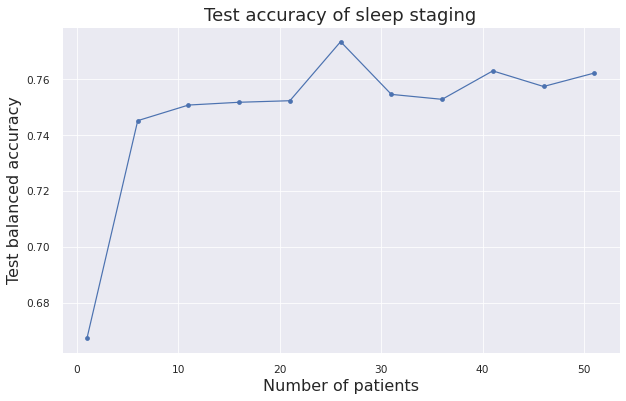

In [37]:
nb_patients = [(1 + i*5) for i in range(len(subjects_dic["full_train_subjects"][::5]))]
nb_windows = [len(train_set) for train_set in train_sets[::5]]


# To add the number of windows
# fig, ax1 = plt.subplots(figsize=(10,6))
# ax1.plot(nb_patients, acc, marker="o");
# ax1.set_xlabel('Number of patients', fontsize=16)
# ax1.set_ylabel('Test accuracy', fontsize=16)
# ax1.set_title('Test accuracy of sleep staging', fontsize=18)
# ax2 = ax1.secondary_xaxis('top')
# ax2.set_xlabel('Number of windows', fontsize=16)
# ax2.set_xticklabels(nb_windows)
# plt.show()


plt.figure(figsize=(10,6));
plt.plot(nb_patients, acc_list, marker="o");
plt.xlabel("Number of patients", fontsize=16);
plt.ylabel("Test balanced accuracy", fontsize=16);
plt.savefig('img/fine_tune_bis.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title("Test accuracy of sleep staging", fontsize=18);

In [48]:
lr = 5e-4
batch_size = 64
max_nb_epochs = 40
early_stopping_patience = 5

acc_list_scratch = []
for train_set in train_sets[::5]:
    encoder_scratch = SleepStagerChambon2018(
        n_channels,
        sfreq,
        n_classes=128,
        n_conv_chs=16,
        input_size_s=window_size,
        dropout=p_dropout,
    )
    encoder_scratch.num_features = 128
    classifier_net = ClassifierNet(encoder_scratch,
                                   p_dropout=0.2)
    _, acc = train_and_test(classifier_net, train_set, valid_set, test_set=test_set, lr=lr, batch_size=batch_size,
                            max_nb_epochs=max_nb_epochs, early_stopping_patience=early_stopping_patience, train_what="all")
    acc_list_scratch.append(acc)
    print("acc:", acc)

  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.2015        1.5092       0.2577           0.2000        1.5379  4.5575


      2           0.2314        1.4625       0.4684           0.2862        1.4641  2.2910


      3           0.3453        1.3397       0.4636           0.2923        1.4766  2.3070


      4           0.3974        1.2778       0.5141           0.3182        1.3874  2.3193


      5           0.4349        1.2500       0.5208           0.3328        1.3785  2.3188


      6           0.4708        1.2310       0.5259           0.3509        1.3724  2.3446


      7           0.5014        1.2091       0.4684           0.3506        1.4273  2.3276


      8           0.5063        1.2064       0.5141           0.3605        1.3854  2.3406


      9           0.4967        1.2087       0.4641           0.3379        1.4397  2.3405


     10           0.4963        1.2124       0.4910           0.3503        1.4119  2.3788


     11           0.5262        1.1835       0.5204           0.3548        1.3818  2.3754


     12           0.5435        1.1697       0.5202           0.3721        1.3780  2.3926


     13           0.5289        1.1799       0.5399           0.3668        1.3604  2.4246


     14           0.5548        1.1618       0.5621           0.3778        1.3355  2.3967


     15           0.5340        1.1688       0.5435           0.3771        1.3535  2.4070


     16           0.5538        1.1547       0.5556           0.3839        1.3411  2.4218


     17           0.5489        1.1607       0.5030           0.3720        1.3882  2.4257


     18           0.5648        1.1496       0.5533           0.3810        1.3418  2.4767


     19           0.5527        1.1595       0.5143           0.3553        1.3845  2.4911


     20           0.5622        1.1478       0.5019           0.3722        1.3930  2.4663


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.6538376342895116


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.2795        1.4156       0.5781           0.3418        1.3227  13.4549


      2           0.3946        1.2992       0.5814           0.3728        1.3125  8.1163


      3           0.4285        1.2795       0.5809           0.3871        1.3145  7.9523


      4           0.4472        1.2666       0.5732           0.4127        1.3252  8.1230


      5           0.4766        1.2449       0.6347           0.4340        1.2689  8.1270


      6           0.4959        1.2276       0.6466           0.4371        1.2528  8.1690


      7           0.5112        1.2152       0.6344           0.4306        1.2642  8.2102


      8           0.5145        1.2118       0.6282           0.4233        1.2689  8.1937


      9           0.5244        1.2032       0.6568           0.4555        1.2438  8.2162


     10           0.5325        1.1960       0.6242           0.4446        1.2748  8.3197


     11           0.5246        1.2025       0.6499           0.4299        1.2496  8.3934


     12           0.5428        1.1882       0.6495           0.4529        1.2506  8.4013


     13           0.5476        1.1843       0.6586           0.4668        1.2409  8.3371


     14           0.5532        1.1790       0.6281           0.4168        1.2713  8.3467


     15           0.5462        1.1834       0.6303           0.4426        1.2657  8.3586


     16           0.5571        1.1747       0.6432           0.4357        1.2559  8.3180


     17           0.5597        1.1742       0.6516           0.4348        1.2481  8.4175


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7239450658987706


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.3325        1.3406       0.5348           0.3203        1.3685  24.4406


      2           0.4259        1.2504       0.5750           0.3816        1.3235  15.3486


      3           0.4822        1.2048       0.5883           0.4078        1.3105  15.4612


      4           0.4978        1.1894       0.5655           0.3617        1.3337  15.5253


      5           0.5006        1.1864       0.5936           0.3982        1.3073  15.3493


      6           0.5128        1.1762       0.6094           0.4156        1.2906  15.5232


      7           0.5197        1.1728       0.6105           0.4208        1.2900  15.7694


      8           0.5197        1.1727       0.6208           0.4248        1.2804  15.6995


      9           0.5313        1.1648       0.6284           0.4512        1.2740  15.6471


     10           0.5332        1.1639       0.6299           0.4509        1.2717  15.8744


     11           0.5444        1.1573       0.6110           0.4304        1.2908  15.8885


     12           0.5375        1.1594       0.6234           0.4269        1.2785  15.6853


     13           0.5470        1.1535       0.6266           0.4482        1.2745  16.0063


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7283752353527523


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4020        1.2709       0.5735           0.3585        1.3205  27.0407


      2           0.4802        1.2046       0.5908           0.3756        1.3102  23.2646


      3           0.5170        1.1758       0.6183           0.4296        1.2830  23.2192


      4           0.5295        1.1668       0.6287           0.4435        1.2729  23.2107


      5           0.5400        1.1616       0.6286           0.4578        1.2753  23.4317


      6           0.5412        1.1602       0.6352           0.4496        1.2649  23.6642


      7           0.5443        1.1583       0.6349           0.4654        1.2659  23.7067


      8           0.5504        1.1541       0.6237           0.4695        1.2782  22.5277


      9           0.5515        1.1538       0.6231           0.4458        1.2788  22.1761


     10           0.5553        1.1512       0.6371           0.4493        1.2655  22.0920


     11           0.5544        1.1500       0.6262           0.4407        1.2744  22.2692


     12           0.5575        1.1499       0.6267           0.4392        1.2748  22.3881


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7335253073430059


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4169        1.2532       0.6141           0.4233        1.2890  38.3316


      2           0.4851        1.1954       0.6278           0.4301        1.2739  28.9338


      3           0.4991        1.1857       0.6463           0.4377        1.2547  29.2144


      4           0.5109        1.1775       0.6449           0.4464        1.2555  28.8926


      5           0.5154        1.1764       0.6388           0.4576        1.2633  29.0520


      6           0.5239        1.1697       0.6423           0.4476        1.2589  28.9679


      7           0.5251        1.1699       0.6274           0.4375        1.2744  28.7858


      8           0.5307        1.1651       0.6213           0.4262        1.2809  29.1513


      9           0.5345        1.1628       0.6287           0.4582        1.2729  29.3382


     10           0.5327        1.1634       0.6341           0.4473        1.2666  29.1486


     11           0.5361        1.1609       0.6250           0.4327        1.2773  28.9804


     12           0.5363        1.1614       0.6297           0.4675        1.2716  29.2080


     13           0.5412        1.1595       0.6349           0.4592        1.2677  29.0500


     14           0.5473        1.1549       0.6326           0.4551        1.2695  28.9184


     15           0.5477        1.1540       0.6355           0.4545        1.2666  29.4787


     16           0.5474        1.1538       0.6055           0.4671        1.2960  29.0697


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7469265699413002


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4161        1.2535       0.6317           0.4251        1.2688  42.3585


      2           0.4923        1.1971       0.6287           0.4307        1.2707  35.8236


      3           0.5079        1.1881       0.6227           0.4376        1.2758  36.8954


      4           0.5218        1.1799       0.6337           0.4554        1.2658  35.4390


      5           0.5329        1.1723       0.6374           0.4482        1.2642  35.4199


      6           0.5356        1.1702       0.6393           0.4601        1.2631  35.9475


      7           0.5396        1.1675       0.6278           0.4313        1.2718  35.7380


      8           0.5425        1.1653       0.6466           0.4608        1.2558  35.2611


      9           0.5458        1.1632       0.6469           0.4621        1.2525  35.6183


     10           0.5526        1.1590       0.6466           0.4719        1.2543  35.6646


     11           0.5502        1.1591       0.6473           0.4714        1.2532  35.4726


     12           0.5548        1.1578       0.6449           0.4655        1.2581  35.8507


     13           0.5567        1.1559       0.6373           0.4473        1.2644  35.9872


     14           0.5584        1.1546       0.6372           0.4552        1.2664  35.5789


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7290397607708495


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4075        1.2612       0.6474           0.4278        1.2548  48.1016


      2           0.4684        1.2103       0.6827           0.4441        1.2177  41.5323


      3           0.5111        1.1822       0.6958           0.4888        1.2038  41.0146


      4           0.5222        1.1738       0.7204           0.4935        1.1803  41.5606


      5           0.5325        1.1667       0.7301           0.4919        1.1713  41.5752


      6           0.5386        1.1635       0.6954           0.5174        1.2038  41.1288


      7           0.5449        1.1610       0.7040           0.5046        1.1973  41.6347


      8           0.5488        1.1568       0.7497           0.5269        1.1529  40.7814


      9           0.5461        1.1589       0.6692           0.4946        1.2315  40.8297


     10           0.5524        1.1573       0.7400           0.5308        1.1625  41.5138


     11           0.5552        1.1525       0.7249           0.5019        1.1766  41.4331


     12           0.5593        1.1527       0.7126           0.5142        1.1897  41.0475


     13           0.5606        1.1490       0.7336           0.5124        1.1683  41.6705


     14           0.5646        1.1476       0.7147           0.5116        1.1874  41.4375


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7589434045852254


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4143        1.2621       0.5980           0.4056        1.3032  53.9627


      2           0.4852        1.2022       0.6203           0.4240        1.2804  46.8861


      3           0.5116        1.1838       0.6333           0.4531        1.2671  47.2374


      4           0.5243        1.1765       0.6443           0.4533        1.2576  47.1062


      5           0.5339        1.1692       0.6286           0.4393        1.2730  46.5461


      6           0.5395        1.1659       0.6388           0.4638        1.2642  47.2971


      7           0.5451        1.1623       0.6402           0.4662        1.2601  47.1252


      8           0.5501        1.1589       0.6313           0.4412        1.2709  46.7118


      9           0.5548        1.1571       0.6384           0.4630        1.2639  47.3050


     10           0.5579        1.1542       0.6382           0.4603        1.2634  46.5967


     11           0.5588        1.1534       0.6334           0.4634        1.2683  47.2104


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7483663750138443


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4285        1.2573       0.6092           0.4257        1.2885  56.1386


      2           0.4826        1.2134       0.6345           0.4243        1.2666  53.4458


      3           0.5026        1.1991       0.6287           0.4410        1.2729  53.0756


      4           0.5191        1.1875       0.6603           0.4656        1.2411  52.7833


      5           0.5331        1.1793       0.6598           0.4635        1.2415  52.8539


      6           0.5372        1.1762       0.6435           0.4642        1.2572  53.0026


      7           0.5448        1.1722       0.6419           0.4662        1.2603  52.6180


      8           0.5498        1.1692       0.6464           0.4867        1.2549  52.3726


      9           0.5546        1.1667       0.6528           0.4692        1.2491  53.3082


     10           0.5577        1.1639       0.6533           0.4784        1.2489  52.8787


     11           0.5581        1.1640       0.6450           0.4800        1.2555  53.2091


     12           0.5649        1.1606       0.6494           0.4833        1.2520  52.6902


     13           0.5673        1.1585       0.6719           0.4971        1.2287  52.7696


     14           0.5680        1.1585       0.6572           0.4740        1.2453  53.1085


     15           0.5703        1.1573       0.6515           0.4778        1.2500  52.8563


     16           0.5704        1.1554       0.6588           0.4762        1.2436  52.4622


     17           0.5721        1.1557       0.6433           0.4824        1.2590  53.0374


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.761933768966663


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4372        1.2458       0.5995           0.3900        1.3007  66.8528


      2           0.5062        1.1938       0.6343           0.4476        1.2681  59.8163


      3           0.5256        1.1811       0.6310           0.4366        1.2710  59.2875


      4           0.5364        1.1744       0.6435           0.4660        1.2594  59.0887


      5           0.5412        1.1720       0.6360           0.4633        1.2658  59.3685


      6           0.5452        1.1703       0.6468           0.4750        1.2557  59.0718


      7           0.5472        1.1692       0.6424           0.4680        1.2595  59.9058


      8           0.5499        1.1663       0.6341           0.4475        1.2690  59.4608


      9           0.5495        1.1666       0.6436           0.4764        1.2587  59.5610


     10           0.5551        1.1632       0.6476           0.4732        1.2554  59.6317


     11           0.5577        1.1618       0.6364           0.4570        1.2660  59.0899


     12           0.5597        1.1615       0.6469           0.4678        1.2564  59.2228


     13           0.5611        1.1596       0.6436           0.4736        1.2592  59.2808


     14           0.5623        1.1594       0.6263           0.4784        1.2762  59.0832


     15           0.5638        1.1592       0.6337           0.4672        1.2695  59.6512


     16           0.5586        1.1622       0.6430           0.4698        1.2598  59.4395


     17           0.5631        1.1596       0.6404           0.4653        1.2632  59.4935


     18           0.5701        1.1571       0.6369           0.4660        1.2663  59.1159


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.755897663085613


  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.4495        1.2368       0.6651           0.4363        1.2354  69.9405


      2           0.5008        1.1956       0.6978           0.4787        1.2040  65.3251


      3           0.5159        1.1842       0.6968           0.4896        1.2047  65.4755


      4           0.5258        1.1786       0.6965           0.4730        1.2057  65.5398


      5           0.5287        1.1774       0.6909           0.4684        1.2106  64.9766


      6           0.5359        1.1726       0.7031           0.4878        1.1977  66.2237


      7           0.5402        1.1699       0.7022           0.5002        1.1990  65.1054


      8           0.5439        1.1663       0.7072           0.4918        1.1953  66.1430


      9           0.5502        1.1633       0.7101           0.4919        1.1900  66.1194


     10           0.5497        1.1623       0.7056           0.4916        1.1956  65.3416


     11           0.5555        1.1600       0.7134           0.4968        1.1896  65.8984


Stopping since valid_bal_acc has not improved in the last 5 epochs.
acc: 0.7470373241776498


In [49]:
print(acc_list_scratch)
#[0.6538376342895116, 0.7239450658987706, 0.7283752353527523, 0.7335253073430059, 0.7469265699413002, 0.7290397607708495, 0.7589434045852254, 0.7483663750138443, 0.761933768966663, 0.755897663085613, 0.7470373241776498]

[0.6538376342895116, 0.7239450658987706, 0.7283752353527523, 0.7335253073430059, 0.7469265699413002, 0.7290397607708495, 0.7589434045852254, 0.7483663750138443, 0.761933768966663, 0.755897663085613, 0.7470373241776498]


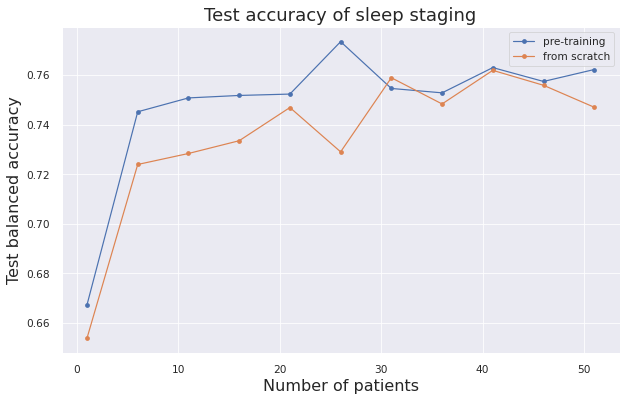

In [50]:
plt.figure(figsize=(10,6));
plt.plot(nb_patients, acc_list, marker="o");
plt.plot(nb_patients, acc_list_scratch, marker="o");
plt.xlabel("Number of patients", fontsize=16);
plt.ylabel("Test balanced accuracy", fontsize=16);
plt.legend(['pre-training', 'from scratch'])
plt.savefig('img/fine_tune.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
plt.title("Test accuracy of sleep staging", fontsize=18);